In [2]:
from ase.io import read
import matplotlib.pyplot as plt
import numpy as np

import abtem

# Multislice simulations

The multislice algorithm works by propagating the $xy$ part of the wave function slice-by-slice forward along the optical axis (which in abTEM is by definition the positive $z$ direction). 
One forward step through a slice of the potential consists of a transmission and a propagation. In the weak-phase approximation the transmission through a slice is just a phase shift proportional to the magnitude of the potential within that. To complete the multislice step, the transmitted wave is propagated by a distance corresponding to the thickness of the slice using the Fresnel free-space approximation.

## Multislice simulations with plane waves

Below we create a `Potential` and a `PlaneWave`:

In [3]:
atoms = read('./data/STO_LTO.cif')

potential = abtem.Potential(atoms, slice_thickness=1, sampling=.05)

wave = abtem.PlaneWave(energy=300e3)

We create a task graph for running a simulation with the multislice algorithm by calling `multislice`.

In [5]:
pw_exit_wave = wave.multislice(potential)

To execute the task graph, we call `compute`.

In [6]:
pw_exit_wave.compute();

[########################################] | 100% Completed |  0.3s


```{note}
Notice that we did not provide the sampling or extent of the wave function above, instead the wave function adopted the grid of the potential. A `GridUndefinedError` will be thrown if the grid is not defined for both the wave function and potential.
```

We can write the wave function to disk and read it again.

In [7]:
pw_exit_wave.to_zarr('data/srtio3_110_exit_wave.zarr', overwrite=True)

In [8]:
imported_wave = abtem.from_zarr('data/srtio3_110_exit_wave.zarr')

assert imported_wave == pw_exit_wave

We can now show the intensity of the resulting exit wave function.

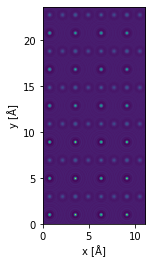

In [9]:
pw_exit_wave.intensity().show();

We also show the Fourier space intensity (i.e. the diffraction pattern). When getting the diffraction pattern, we set `block_direct=True` to block the direct beam. The direct beam typically has a much higher intensity than the scattered beams and thus can't be show it on the same scale. 

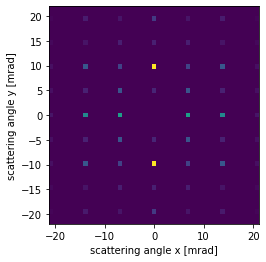

In [9]:
pw_exit_wave.diffraction_patterns(block_direct=True, max_angle=21).show(units='mrad');

```{note}
The diffraction spot looks like squares. This is because the incoming beam is a periodic (and effectively infinite) plane wave, hence the diffraction spots are points with no size. However, we are discretizing the wave function on a square grid (i.e. pixels), hence the spots can only be as small as single pixels.
```

## Multislice simulation with a probe
For a probe, we need to provide the convergence semiangle (in mrad) via `semiangle_cutoff`.

In [10]:
probe = abtem.Probe(energy=200e3, semiangle_cutoff=30)

We want to position the probe on an atom hence we obtain the `xy` position of one of the atoms.

In [11]:
position = atoms.positions[0][:2]

positions = np.tile(position[None], (5, 1))
positions[:,0] += np.linspace(-.5, .5, 5)

We then simulate the exit wave via a multislice simulation of the probe placed at this position.

In [12]:
probe_exit_wave = probe.multislice(scan=positions, potential=potential)

probe_exit_wave.compute();

[########################################] | 100% Completed |  0.7s


The convergent-beam electron diffraction (CBED) pattern can be calculated in the same manner as the ED pattern. We again display the result on a log scale. Note that to get more useful results, we should go back and increase our sampling of the potential.

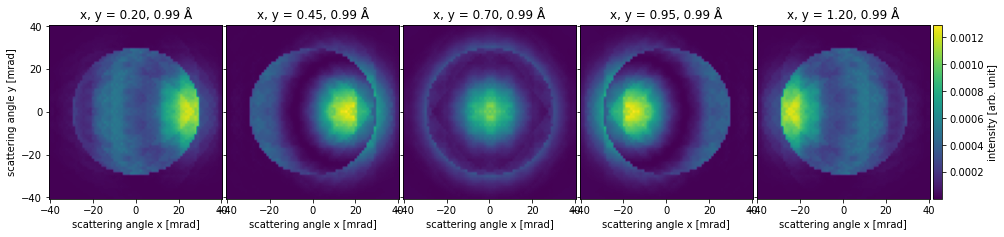

In [25]:
cbed_diffraction_pattern = probe_exit_wave.diffraction_patterns(max_angle=40)

ax, im = cbed_diffraction_pattern.show(units = 'mrad', 
                                       explode = True, 
                                       figsize = (16, 5), 
                                       common_color_scale = True, 
                                       cbar = True, 
                                       image_grid_kwargs = {'axes_pad': .05})

## Thickness series
CBED is often used for determining sample the thickness by comparing an experiment to a thickness series. 


In [35]:
potential_thickness = abtem.Potential(atoms, slice_thickness=1, exit_planes=2)

wave_thickness = abtem.PlaneWave(energy=300e3, sampling=.05, normalize=True)

In [36]:
exit_waves_thickness = wave.multislice(potential_thickness).compute()

[########################################] | 100% Completed |  0.4s


In [37]:
diffraction_patterns_thickness = exit_waves[::3].diffraction_patterns(max_angle=20).block_direct()

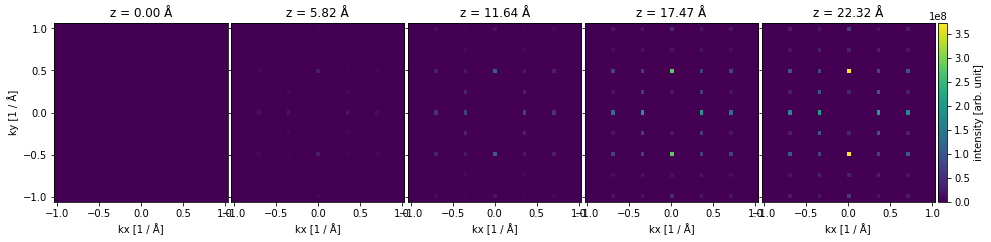

In [38]:
diffraction_patterns.show(explode = True, 
                          figsize = (16, 5),
                          common_color_scale = True,
                          cbar = True,
                          image_grid_kwargs = {'axes_pad': .05},
                          );

## Small-angle beam tilt